In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: True


In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [ ]:
def reshape_instance(ins):
  _,size,_,_=ins.shape        #?
  return ins.reshape(3,size,25)


In [ ]:
def crop_clip(data , length=300):
  for item_iter in range(len(data)):
    if data[item_iter].shape[1]>length:
      data[item_iter]= data[item_iter][:,:length,:] #?
  return data

### Loading Dataset pickles

In [ ]:
import pickle
with open('/content/drive/MyDrive/Park/train_3d.pkl', 'rb') as f:
    train_data = pickle.load(f)
    # train_label = [int(i['label']/10) for i in train_data]
    train_label = [i['label'] for i in train_data]
    print(train_label[:10])
    train_data = [reshape_instance(i['keypoint']) for i in train_data]

with open('/content/drive/MyDrive/Park/test_3d.pkl', 'rb') as f:
    test_data = pickle.load(f)
    # test_label = [int(i['label']/10) for i in test_data]
    test_label = [i['label'] for i in test_data]
    print(test_label[:10])
    test_data = [reshape_instance(i['keypoint']) for i in test_data]


with open('/content/drive/MyDrive/Park/val_3d.pkl', 'rb') as f:
    val_data = pickle.load(f)
    # val_label = [int(i['label']/10) for i in val_data]
    val_label = [i['label'] for i in val_data]
    print(val_label[:10])
    val_data = [reshape_instance(i['keypoint']) for i in val_data]

train_data = crop_clip(train_data)
test_data = crop_clip(test_data)
val_data = crop_clip(val_data)

[71, 24, 87, 93, 69, 51, 21, 79, 36, 79]
[21, 63, 87, 1, 2, 59, 30, 16, 8, 26]
[5, 9, 52, 93, 4, 71, 59, 13, 7, 87]


In [ ]:
max(train_label)

96

### Defining collator and feeder

In [ ]:
from keras.preprocessing import sequence
from torch.nn.utils.rnn import pad_sequence
class MyCollator(object):   #?
    def __init__(self,test=False,percentile=4750):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        # data = [torch.Tensor(item[0]) for item in batch]



        # data = pad_sequence(data, padding_value=0)
        # target = pad_sequence(target, padding_value=0)
        # target = torch.Tensor(target)
        # for items in batch:
        #   if items[0].shape[1]>300:
        #     items[0]= items[0][:,:300,:,:]
        max_len = 300
        max_len2 = max([x[0].shape[2] for x in batch])

        # return [data, target]
        batch = sorted(batch, key=lambda x: x[0].shape[1], reverse=True)
        target = [item[1] for item in batch]
        data = [torch.Tensor(item[0]) for item in batch]
        # Pad the sequences to the length of the longest sequence in the batch
        # padded_batch = pad_sequence(data, batch_first=True, padding_value=0)
        padded_batch = [torch.nn.functional.pad(torch.Tensor(gif[0]), ( 0,0,max_len - gif[0].shape[1], 0)) for gif in batch]
        # stack = [[seq[i],label[i]] for i in range(padded_batch.shape[0])]

        return [torch.stack(padded_batch),target]

class MyCollator_backup(object):
    def __init__(self,test=False,percentile=4750):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        # data = [torch.Tensor(item[0]) for item in batch]



        # data = pad_sequence(data, padding_value=0)
        # target = pad_sequence(target, padding_value=0)
        # target = torch.Tensor(target)
        max_len = max([x[0].shape[1] for x in batch])
        max_len2 = max([x[0].shape[2] for x in batch])

        # return [data, target]
        batch = sorted(batch, key=lambda x: x[0].shape[1], reverse=True)
        target = [item[1] for item in batch]
        data = [torch.Tensor(item[0]) for item in batch]
        # Pad the sequences to the length of the longest sequence in the batch
        # padded_batch = pad_sequence(data, batch_first=True, padding_value=0)
        padded_batch = [torch.nn.functional.pad(torch.Tensor(gif[0]), ( 0,0,max_len - gif[0].shape[1], 0)) for gif in batch]
        # stack = [[seq[i],label[i]] for i in range(padded_batch.shape[0])]

        return [torch.stack(padded_batch),target]

# def pad_collate(batch):
#   data = [item[0] for item in batch]
#         target = [item[1] for item in batch]
#         target = torch.LongTensor(target)

#   xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
#   yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

#   return xx_pad, yy_pad, x_lens, y_lens


In [ ]:

class Feeder(torch.utils.data.Dataset):
  def __init__(self, data, label):
      super().__init__()
      self.label = label
      self.data = data

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

### Defining Graph to load data in the way ntu+rgb D models give it to action recongnition model

In [ ]:
class Graph():
  def __init__(self, hop_size, strategy):
    self.get_edge()

    self.hop_size = hop_size
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    self.get_adjacency(strategy)

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)]
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.self_link = self_link
    self.neighbor_link = neighbor_link
    self.edge = self_link + neighbor_link
    self.center = 21 - 1     #?

  def get_adjacency(self, strategy):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    if strategy == 'spatial':
      A = []
      for hop in valid_hop:
          a_root = np.zeros((self.num_node, self.num_node))
          a_close = np.zeros((self.num_node, self.num_node))
          a_further = np.zeros((self.num_node, self.num_node))
          for i in range(self.num_node):
              for j in range(self.num_node):
                  if self.hop_dis[j, i] == hop:
                      if self.hop_dis[j, self.center] == self.hop_dis[
                              i, self.center]:
                          a_root[j, i] = normalize_adjacency[j, i]
                      elif self.hop_dis[j, self.center] > self.hop_dis[
                              i, self.center]:
                          a_close[j, i] = normalize_adjacency[j, i]
                      else:
                          a_further[j, i] = normalize_adjacency[j, i]
          if hop == 0:
              A.append(a_root)
          else:
              A.append(a_root + a_close)
              A.append(a_further)
      A = np.stack(A)
      self.A = A
    elif strategy == 'agcn':
      A = []
      link_mat = self.edge2mat(self.self_link, self.num_node)
      In = self.normalize_digraph(self.edge2mat(self.neighbor_link, self.num_node))
      outward = [(j, i) for (i, j) in self.neighbor_link]
      Out = self.normalize_digraph(self.edge2mat(outward, self.num_node))
      A = np.stack((link_mat, In, Out))
      self.A = A
    else:
        raise ValueError('Do Not Exist This Strategy')

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

  def edge2mat(self, link, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A

### Attention Module class

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

### STGCN Backbone

In [ ]:
class SpatialGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)

  def forward(self, x, A):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

In [ ]:
class STGC_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
        super().__init__()

        self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                           out_channels=out_channels,
                                           s_kernel_size=A_size[0])


        self.M = nn.Parameter(torch.ones(A_size))

        self.tgc = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels,
                      out_channels,
                      (t_kernel_size, 1),
                      (stride, 1),
                      ((t_kernel_size - 1) // 2, 0)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        # Add channel attention
        self.channel_attention = ChannelAttention(out_channels)

    def forward(self, x, A):
        x = self.tgc(self.sgc(x, A * self.M))

        # Apply channel attention
        x = self.channel_attention(x)

        return x


In [ ]:
# class STGC_block(nn.Module):
#   def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
#     super().__init__()

#     self.sgc = SpatialGraphConvolution(in_channels=in_channels,
#                                        out_channels=out_channels,
#                                        s_kernel_size=A_size[0])

#     self.M = nn.Parameter(torch.ones(A_size))

#     self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
#                             nn.ReLU(),
#                             nn.Dropout(dropout),
#                             nn.Conv2d(out_channels,
#                                       out_channels,
#                                       (t_kernel_size, 1),
#                                       (stride, 1),
#                                       ((t_kernel_size - 1) // 2, 0)),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU())

#   def forward(self, x, A):
#     x = self.tgc(self.sgc(x, A * self.M))
#     return x

In [ ]:
class ST_GCN(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1])

    # STGC_blocks
    self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
    self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node
    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x


### AGCN Backbone

In [ ]:
import math


def kaiming_init(module: nn.Module,
                 a: float = 0,
                 mode: str = 'fan_out',
                 nonlinearity: str = 'relu',
                 bias: float = 0,
                 distribution: str = 'normal') -> None:
    assert distribution in ['uniform', 'normal']
    if hasattr(module, 'weight') and module.weight is not None:
        if distribution == 'uniform':
            nn.init.kaiming_uniform_(
                module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
        else:
            nn.init.kaiming_normal_(
                module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)


def constant_init(module: nn.Module, val: float, bias: float = 0) -> None:
    if hasattr(module, 'weight') and module.weight is not None:
        nn.init.constant_(module.weight, val)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)


def normal_init(module: nn.Module,
                mean: float = 0,
                std: float = 1,
                bias: float = 0) -> None:
    if hasattr(module, 'weight') and module.weight is not None:
        nn.init.normal_(module.weight, mean, std)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)



def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    normal_init(weight, mean=0, std=math.sqrt(2. / (n * k1 * k2 * branches)))
    constant_init(conv.bias, 0)

def conv_init(conv):
    kaiming_init(conv.weight)
    constant_init(conv.bias, 0)

def bn_init(bn, scale):
    constant_init(bn.weight, scale)
    constant_init(bn.bias, 0)


def zero(x):
    """return zero."""
    return 0


def identity(x):
    """return input itself."""
    return x

In [ ]:
class ConvTemporalGraphical(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 adj_len=25,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        # 3 for 2sagcn 5 for stgcn
        self.PA = nn.Parameter(torch.FloatTensor(3, adj_len, adj_len))
        torch.nn.init.constant_(self.PA, 1e-6)

        self.num_subset = 3
        inter_channels = out_channels // 4
        self.inter_c = inter_channels
        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))

        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels))
        else:
            self.down = lambda x: x

        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.conv_d[i], self.num_subset)

    def forward(self, x, adj_mat):
        """Defines the computation performed at every call."""
        assert adj_mat.size(0) == self.kernel_size

        N, C, T, V = x.size()
        A = adj_mat + self.PA

        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(
                N, V, self.inter_c * T)
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            A1 = self.soft(torch.matmul(A1, A2) / A1.size(-1))  # N V V
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)

        return self.relu(y), adj_mat

In [ ]:
class AGCNBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 adj_len=25,
                 dropout=0,
                 residual=True):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = ConvTemporalGraphical(
            in_channels, out_channels, kernel_size[1], adj_len=adj_len)
        self.tcn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, (kernel_size[0], 1),
                      (stride, 1), padding), nn.BatchNorm2d(out_channels))

        # tcn init
        for m in self.tcn.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)

        if not residual:
            self.residual = zero

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = identity

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)), nn.BatchNorm2d(out_channels))

        self.relu = nn.ReLU(inplace=True)

        # put list of attention here ['pam', 'cam']
        self.att_type = []
        self.attention = len(self.att_type)
        if self.attention > 0:
          self.channel_attention = ChannelAttention(out_channels)

    def forward(self, x, adj_mat):
        """Defines the computation performed at every call."""
        res = self.residual(x)
        x, adj_mat = self.gcn(x, adj_mat)

        if self.attention == 1 and self.att_type[0] == 'pam' :
          x = self.channel_attention(x)
          x = self.tcn(x)
          x = x + res
        elif self.attention == 1 and self.att_type[0] == 'cam':
          x = self.tcn(x)
          x = self.channel_attention(x)
          x = x + res
        else:
          x = self.tcn(x) + res

        if self.attention == 2:
          x = self.channel_attention(x)

        return self.relu(x), adj_mat

In [ ]:
class AGCN(nn.Module):

    def __init__(self,
                 in_channels,
                 hop_size,
                 strategy,
                 pretrained=None,
                 **kwargs):
        super().__init__()

        # load graph
        self.graph = Graph(hop_size, strategy)
        A = torch.tensor(
            self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)
        A_size = A.size()

        # build networks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.bn = nn.BatchNorm1d(in_channels * A_size[1])


        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}
        self.agcn_networks = nn.ModuleList((
            AGCNBlock(
                in_channels,
                64,
                kernel_size,
                1,
                adj_len=A.size(1),
                residual=False,
                **kwargs0),
            AGCNBlock(64, 64, kernel_size, 1,adj_len=A.size(1), **kwargs),
            AGCNBlock(64, 64, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(64, 64, kernel_size, 1,adj_len=A.size(1), **kwargs),
            AGCNBlock(64, 128, kernel_size, 2, adj_len=A.size(1), **kwargs),
            AGCNBlock(128, 128, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(128, 128, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(128, 256, kernel_size, 2, adj_len=A.size(1), **kwargs),
            AGCNBlock(256, 256, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(256, 256, kernel_size, 1, adj_len=A.size(1), **kwargs),
        ))

    def forward(self, x):
        """Defines the computation performed at every call.
        Args:
            x (torch.Tensor): The input data.

        Returns:
            torch.Tensor: The output of the module.
        """
        # data normalization
        N, C, T, V = x.size() # batch, channel, frame, node
        x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
        x = self.bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

        for gcn in self.agcn_networks:
            x, _ = gcn(x, self.A)

        return x

### STGCN head

In [ ]:
class STGCNHead(nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels,
                 loss_cls=dict(type='CrossEntropyLoss'),
                 spatial_type='avg',
                 num_person=1,
                 init_std=0.01,
                 **kwargs):
        super().__init__()

        self.spatial_type = spatial_type
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_person = num_person
        self.init_std = init_std

        self.pool = None
        if self.spatial_type == 'avg':
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
        elif self.spatial_type == 'max':
            self.pool = nn.AdaptiveMaxPool2d((1, 1))
        else:
            raise NotImplementedError

        self.fc = nn.Conv2d(self.in_channels, self.num_classes, kernel_size=1)

    def init_weights(self):
        normal_init(self.fc, std=self.init_std)

    def forward(self, x):
        # global pooling
        assert self.pool is not None
        x = self.pool(x)
        x = x.view(x.shape[0] // self.num_person, self.num_person, -1, 1,
                   1).mean(dim=1)

        # prediction
        x = self.fc(x)
        x = x.view(x.shape[0], -1)

        return x

### Model Definition

#### STGCN

In [ ]:
class STGCN(nn.Module):
  def __init__(self,
               num_classes,
               in_channels,
               t_kernel_size,
               hop_size,
               strategy='spatial'):
    super().__init__()

    self.agcn = AGCN(in_channels, hop_size, strategy)
    self.stgcnhead = STGCNHead(num_classes, in_channels=256)

  def forward(self, x):
    x = self.agcn(x)
    x = self.stgcnhead(x)

    return x


#### 2SAGCN

In [ ]:
class TWO_SAGCN(nn.Module):
  def __init__(self,
               num_classes,
               in_channels,
               t_kernel_size,
               hop_size,
               strategy='agcn'):
    super().__init__()

    self.agcn = AGCN(in_channels, hop_size, strategy)
    self.stgcnhead = STGCNHead(num_classes, in_channels=256)

  def forward(self, x):
    x = self.agcn(x)
    x = self.stgcnhead(x)

    return x


### Training Loop

In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

NUM_EPOCH = 80
BATCH_SIZE = 32
CUDA_LAUNCH_BLOCKING=1
if(torch.cuda.is_available()):
  model = STGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2).cuda()
else:
  model = STGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2)



optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()


data_loader = dict()
collator = MyCollator()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data=train_data, label=train_label), batch_size=BATCH_SIZE, shuffle=True,collate_fn=collator)
data_loader['valid'] = torch.utils.data.DataLoader(dataset=Feeder(data=val_data, label=val_label), batch_size=BATCH_SIZE, shuffle=True,collate_fn=collator)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data=test_data, label=test_label), batch_size=BATCH_SIZE, shuffle=False,collate_fn=collator)


model.train()

for epoch in range(1, NUM_EPOCH+1):
  correct_train = 0
  sum_loss = 0
  model.train()
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    # print(data)
    if(torch.cuda.is_available()):
      data = data.cuda()
      label = torch.LongTensor(label).cuda()
    else:
      data = data
      label = torch.LongTensor(label)


    output = model(data)
    # print(len(output),len(label))
    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct_train += (predict == label).sum().item()

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
      for data, label in data_loader['valid']:
          if(torch.cuda.is_available()):
            data = data.cuda()
            label = torch.LongTensor(label).cuda()
          else:
            data = data
            label = torch.LongTensor(label)
          outputs = model(data)
          val_loss =criterion(outputs, label)

          sum_loss += val_loss.item()
          _, predict = torch.max(outputs.data, 1)
          correct += (predict == label).sum().item()



  print('# Epoch: {} | Train Loss: {:.4f} | Train Accuracy: {:.4f} | Val loss: {:.4f} | Val Accuracy: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset),(100. * correct_train / len(data_loader['train'].dataset)),val_loss/len(data_loader['valid'].dataset), (100. * correct / len(data_loader['valid'].dataset))))

KeyboardInterrupt: ignored

### Evaluation of Model

<ipython-input-29-ec41cddacf3a>:26: RuntimeWarning: invalid value encountered in double_scalars
  confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)


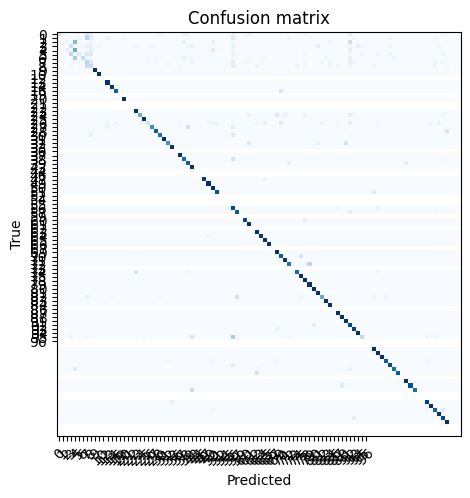

# Test Accuracy: 81.546[%]


In [ ]:
model.eval()

correct = 0
confusion_matrix = np.zeros((100, 100))
with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    if(torch.cuda.is_available()):
      data = data.cuda()
      label = torch.LongTensor(label).cuda()
    else:
      data = data
      label = torch.LongTensor(label)

    output = model(data)

    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = np.unique(train_label,return_counts=False)
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print('# Test Accuracy: {:.3f}[%]'.format(100. * correct / len(data_loader['test'].dataset)))

### Making onnx Models for graphical purpose

In [ ]:
!pip install -q onnx

In [ ]:
input_names = ["Skeleton"]
output_names = ["Parkinson Prediction"]

stgcn_model = STGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2)

for data, label in data_loader['train']:
  x = data
  break

torch.onnx.export(stgcn_model, x, "stgcn_model.onnx", input_names=input_names, output_names=output_names)

<ipython-input-17-9bd303d41e8a>:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert adj_mat.size(0) == self.kernel_size


In [ ]:
input_names = ["Skeleton"]
output_names = ["Parkinson Prediction"]

two_sagcn_model = TWO_SAGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2)

for data, label in data_loader['train']:
  x = data
  break

torch.onnx.export(two_sagcn_model, x, "2sagcn_model.onnx", input_names=input_names, output_names=output_names)

<ipython-input-46-9d11ec776356>:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert adj_mat.size(0) == self.kernel_size
